## Now use selective polynomial expansion with Lasso

## Commentary:



## Use lasso regression to model; compare to OLS

Try lasso regression to see if L1 regularization is helpful.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline,  make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# read cleaned data
dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

In [4]:
# note data is sorted by time
dfModelAll.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
0,0.0,2.2824,CA,10.734315,0
1,21.0,1.8504,CA,11.108701,0
2,26.0,2.3076,CA,8.667013,0
3,84.0,2.3316,CA,13.270286,0
4,111.0,0.9300,CA,14.654839,0


In [5]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 0 to 364211
Data columns (total 5 columns):
num_days         364212 non-null float64
size_kw          364212 non-null float64
state            364212 non-null category
cost_per_watt    364212 non-null float64
scaleSize        364212 non-null int64
dtypes: category(1), float64(3), int64(1)
memory usage: 14.2 MB


### Also prep the whole data set.

### Important: since the data is sorted by time, it needs to be shuffed first or cross_val_score will pick bad sets.

In [33]:
# now the whole model; shuffle it though
dfMod = pd.get_dummies(dfModelAll, drop_first=True).sample(frac=1.0, random_state=21)

### Regress on time, size and state

In [34]:
theCols = dfMod100k.columns; theCols

Index(['num_days', 'size_kw', 'cost_per_watt', 'scaleSize', 'state_AZ',
       'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
       'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

#### chose one of these cells to set X and y

In [35]:
# the whloe dataset - prep data and target
X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

### Bring in the right transformer

In [36]:
### make it an estimator and a transformer for general use
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

#### Make a pipeline for OLS

In [37]:
theStates = ['state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
             'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR', 
             'state_PA', 'state_TX', 'state_VT', 'state_WI']

In [38]:
theOLSPipe = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_days', 'size_kw'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('LR', LinearRegression())
]) # end of Pipeline

#### Make a pipeline for Lasso

In [39]:
theLassoPipe = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_days', 'size_kw'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('Lasso', Lasso())
]) # end of Pipeline

In [29]:
theLassoPipe.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'Lasso', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__num_vars', 'features__cat_vars', 'features__num_vars__memory', 'features__num_vars__steps', 'features__num_vars__extract', 'features__num_vars__scale', 'features__num_vars__poly', 'features__num_vars__extract__columns', 'features__num_vars__scale__copy', 'features__num_vars__scale__with_mean', 'features__num_vars__scale__with_std', 'features__num_vars__poly__degree', 'features__num_vars__poly__include_bias', 'features__num_vars__poly__interaction_only', 'features__cat_vars__columns', 'Lasso__alpha', 'Lasso__copy_X', 'Lasso__fit_intercept', 'Lasso__max_iter', 'Lasso__normalize', 'Lasso__positive', 'Lasso__precompute', 'Lasso__random_state', 'Lasso__selection', 'Lasso__tol', 'Lasso__warm_start'])

Fitting 4 folds for each of 5 candidates, totalling 20 fits


C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

Best parameters: {'Lasso__alpha': 0.0001, 'features__num_vars__poly__degree': 17}
test R squared: 0.5264520444917135


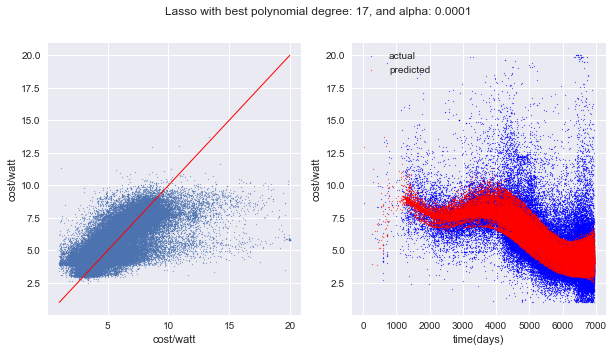

In [48]:

X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

# Specify the hyperparameter space.
poly_space = np.array([17])
alpha_space = np.logspace(-4, 0, 5)
# Create the hyperparameter grid
param_grid = {'features__num_vars__poly__degree': poly_space,
              'Lasso__alpha': alpha_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(theLassoPipe, param_grid, cv=4, return_train_score=True, verbose=True)

# Fit to the training set
model = gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sTitle = 'Lasso with best polynomial degree: {}, and alpha: {}'
fig.suptitle(sTitle.format(gs_cv.best_params_['features__num_vars__poly__degree'],
                           gs_cv.best_params_['Lasso__alpha']))

ax1.scatter(y_test, model.predict(X_test), marker='.', s=4, alpha=0.5);
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red')
ax1.set_ylabel('cost/watt')
ax1.set_xlabel('cost/watt')

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='blue', s=4, alpha=0.5, label='actual')
ax2.scatter(X_test.iloc[:, 0], model.predict(X_test), marker='.', color='red', s=4, alpha=0.5, label='predicted')
ax2.set_ylabel('cost/watt')
ax2.set_xlabel('time(days)')
ax2.legend()
plt.show();

In [46]:
model.cv_results_

{'mean_fit_time': array([20.1583, 18.8458, 18.867 , 14.2821, 13.9361]),
 'mean_score_time': array([0.2196, 0.2725, 0.1913, 0.1579, 0.1915]),
 'mean_test_score': array([0.5191, 0.5188, 0.514 , 0.4633, 0.1569]),
 'mean_train_score': array([0.5194, 0.5191, 0.5142, 0.4634, 0.157 ]),
 'param_Lasso__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_features__num_vars__poly__degree': masked_array(data=[7, 7, 7, 7, 7],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'Lasso__alpha': 0.0001, 'features__num_vars__poly__degree': 7},
  {'Lasso__alpha': 0.001, 'features__num_vars__poly__degree': 7},
  {'Lasso__alpha': 0.01, 'features__num_vars__poly__degree': 7},
  {'Lasso__alpha': 0.1, 'features__num_vars__poly__degree': 7},
  {'Lasso__alpha': 1.0, 'features__num_vars__poly__degree': 7}],
 'rank_test_sco

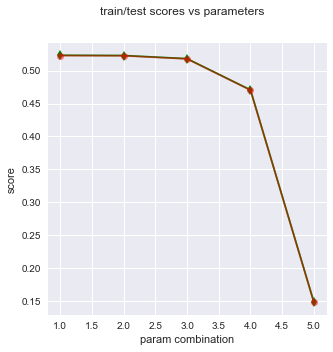

In [49]:
trainVsTest(model.cv_results_)




### What does the above say?


Fitting 4 folds for each of 5 candidates, totalling 20 fits


C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\saus\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase t

Best parameters: {'Lasso__alpha': 0.0001, 'features__num_vars__poly__degree': 10}
test R squared: 0.5252632354716954


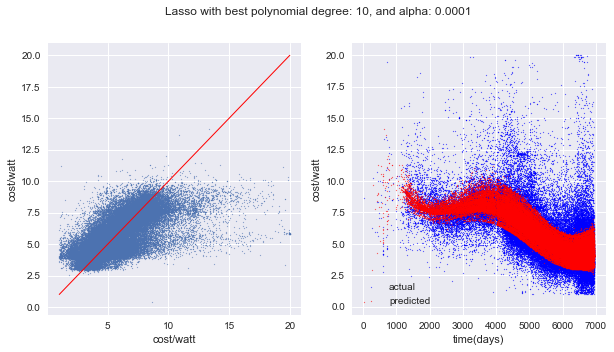

In [50]:

X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

# Specify the hyperparameter space.
poly_space = np.array([10])
alpha_space = np.logspace(-4, 0, 5)
# Create the hyperparameter grid
param_grid = {'features__num_vars__poly__degree': poly_space,
              'Lasso__alpha': alpha_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(theLassoPipe, param_grid, cv=4, return_train_score=True, verbose=True)

# Fit to the training set
model = gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sTitle = 'Lasso with best polynomial degree: {}, and alpha: {}'
fig.suptitle(sTitle.format(gs_cv.best_params_['features__num_vars__poly__degree'],
                           gs_cv.best_params_['Lasso__alpha']))

ax1.scatter(y_test, model.predict(X_test), marker='.', s=4, alpha=0.5);
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red')
ax1.set_ylabel('cost/watt')
ax1.set_xlabel('cost/watt')

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='blue', s=4, alpha=0.5, label='actual')
ax2.scatter(X_test.iloc[:, 0], model.predict(X_test), marker='.', color='red', s=4, alpha=0.5, label='predicted')
ax2.set_ylabel('cost/watt')
ax2.set_xlabel('time(days)')
ax2.legend()
plt.show();